In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsforecast import StatsForecast
from pmdarima import auto_arima
from statsforecast.models import AutoARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [8]:
file_path = "AirPassenge.csv" 
df = pd.read_csv(file_path) 
df['Month'] = pd.to_datetime(df['Month']) 
df = df.set_index('Month').resample('MS').mean() 
df = df.interpolate() 
df.reset_index(inplace=True) 
print(df.head())

       Month  #Passengers
0 1949-01-01        112.0
1 1949-02-01        118.0
2 1949-03-01        132.0
3 1949-04-01        129.0
4 1949-05-01        121.0


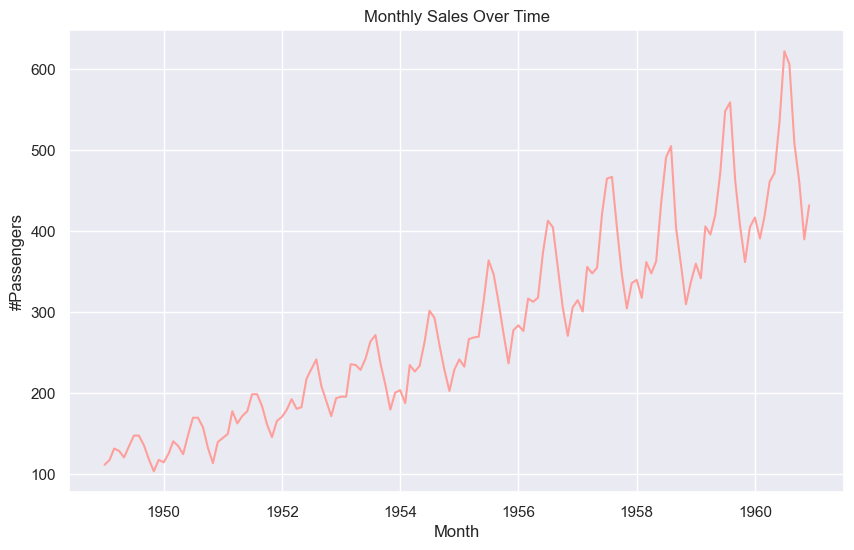

In [9]:
sns.set(style="darkgrid") 
plt.figure(figsize=(10,6)) 
sns.lineplot(x="Month",y="#Passengers",data=df,color='#ff9f9b') 
plt.title('Monthly Sales Over Time') 
plt.xlabel('Month') 
plt.ylabel('#Passengers') 
plt.show()

In [11]:
result = seasonal_decompose(df['#Passengers'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))

result.observed.plot(ax=ax1, color="blue")
ax1.set_ylabel('Observed')

result.trend.plot(ax=ax2, color='blue')
ax2.set_ylabel('Trend')

result.seasonal.plot(ax=ax3, color='blue')
ax3.set_ylabel('Seasonal')

result.resid.plot(ax=ax4, color='blue')
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [12]:
#Train-Test Split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print(f'Train set size: {len(train)}')
print(f'Test set size: {len(test)}')

Train set size: 115
Test set size: 29


In [13]:
pmdarima_model = auto_arima(train['#Passengers'],seasonal=True,m=12) 
pmdarima_forecast = pmdarima_model.predict(n_periods=len(test)) 
pmdarima_forecast_df = pd.DataFrame({'Date':test["Month"],'PMDARIMA_Forecast':pmdarima_forecast})

In [14]:
ets_model = ExponentialSmoothing(train['#Passengers'],seasonal='mul',seasonal_periods=12).fit() 
ets_forecast = ets_model.forecast(steps=len(test)) 
ets_forecast_df = pd.DataFrame({'Date':test["Month"],'ETS_Forecast':ets_forecast}) 


In [15]:
train_ = pd.DataFrame({'unique_id':[1]*len(train),
        'ds': train["Month"], "y":train['#Passengers']})

test_ = pd.DataFrame({'unique_id':[1]*len(test),
        'ds': test["Month"], "y":test['#Passengers']})

sf_forecast = StatsForecast(models = [AutoARIMA(season_length = 12)],freq = 'MS')

sf_forecast.fit(train_)
sf_prediction = sf_forecast.predict(h=len(test))
sf_prediction.rename(columns={'ds': 'Month'}, inplace=True)

c:\Users\石天辰\.conda\envs\pytorch\lib\site-packages\statsforecast\core.py:528: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [16]:
models = [LinearRegression(),lgb.LGBMRegressor(verbosity=-1),xgb.XGBRegressor(),RandomForestRegressor(random_state=0)]
@njit 
def rolling_mean_3(x):
    return rolling_mean(x,window_size=3) 
@njit 
def rolling_mean_6(x):
    return rolling_mean(x,window_size=6) 
fcst = MLForecast(
    models=models,
    freq='MS',
    lags= [1,3,5,7,12],
    lag_transforms={
        1: [expanding_mean],
        3: [rolling_mean_3, rolling_mean_6],
        5: [rolling_mean_3, rolling_mean_6],
        7: [rolling_mean_3, rolling_mean_6],
        12: [rolling_mean_3, rolling_mean_6],
    },
    date_features=['year','month','day','quarter'],
    target_transforms=[Differences([1])]) 
fcst.fit(train_) 
ml_prediction = fcst.predict(len(test_)) 
ml_prediction.rename(columns={'ds':'Month'},inplace=True)

In [17]:
fcst_result = test.copy()
fcst_result.set_index("Month", inplace=True)
fcst_result["AutoARIMA_fcst"]=sf_prediction["AutoARIMA"].values
fcst_result["PMDArima_fcst"]=pmdarima_forecast_df["PMDARIMA_Forecast"].values
fcst_result["ETS_fcst"]=ets_forecast_df["ETS_Forecast"].values
fcst_result["LinearRegression_fcst"]=ml_prediction["LinearRegression"].values
fcst_result["LGBM_fcst"]=ml_prediction["LGBMRegressor"].values
fcst_result["XGB_fcst"]=ml_prediction["XGBRegressor"].values
fcst_result["RandomForest_fcst"]=ml_prediction["RandomForestRegressor"].values
print(fcst_result.head())

            #Passengers  AutoARIMA_fcst  PMDArima_fcst    ETS_fcst  \
Month                                                                
1958-08-01        505.0      490.318247     490.337911  483.662260   
1958-09-01        404.0      427.871463     427.883043  422.747375   
1958-10-01        359.0      370.757341     370.771413  364.795534   
1958-11-01        310.0      328.780883     328.794272  315.747782   
1958-12-01        337.0      359.776026     359.789591  353.312406   

            LinearRegression_fcst   LGBM_fcst    XGB_fcst  RandomForest_fcst  
Month                                                                         
1958-08-01             503.591827  498.358811  491.789518             489.60  
1958-09-01             445.771264  461.122868  432.241365             436.75  
1958-10-01             385.019026  418.246896  378.853464             385.05  
1958-11-01             340.651266  375.113431  345.954549             341.21  
1958-12-01             368.910116  

In [19]:
import numpy as np 


In [20]:
def calculate_error_metrics(actual_values, predicted_values):
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    metrics_dict = {
        'MAE': np.mean(np.abs(actual_values - predicted_values)),
        'RMSE': np.sqrt(np.mean((actual_values - predicted_values)**2)),
        'MAPE': np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100,
        'SMAPE': 100 * np.mean(2 * np.abs(predicted_values - actual_values) / (np.abs(predicted_values) + np.abs(actual_values))),
        'MdAPE': np.median(np.abs((actual_values - predicted_values) / actual_values)) * 100,
        'GMRAE': np.exp(np.mean(np.log(np.abs(actual_values - predicted_values) / actual_values)))
    }

    result_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])
    return result_df


actuals = fcst_result['#Passengers']
error_metrics_dict = {} 
for col in fcst_result.columns[1:]:
    predicted_values = fcst_result[col] 
    error_metrics_dict[col] = calculate_error_metrics(actuals,predicted_values)['Value'].values 
error_metrics_df = pd.DataFrame(error_metrics_dict).T.reset_index() 
error_metrics_df.columns = ['Model','MAE','RMSE','MAPE','SMAPE','MdAPE','GMRAE'] 
error_metrics_df

,Model,MAE,RMSE,MAPE,SMAPE,MdAPE,GMRAE
0,AutoARIMA_fcst,28.567120,35.102924,6.128737,6.349770,6.058349,0.046138
1,PMDArima_fcst,28.547409,35.082813,6.124550,6.345217,6.060148,0.046005
2,ETS_fcst,50.403823,61.843577,10.726908,11.580638,10.447564,0.075040
3,LinearRegression_fcst,31.021877,37.440283,7.152104,7.185313,7.383269,0.050875
4,LGBM_fcst,44.332040,54.381438,10.878859,10.079661,10.720302,0.069730
5,XGB_fcst,25.636881,29.811818,6.299290,6.035188,6.070724,0.044246
6,RandomForest_fcst,27.054828,32.481266,6.518869,6.229710,6.548596,0.044582


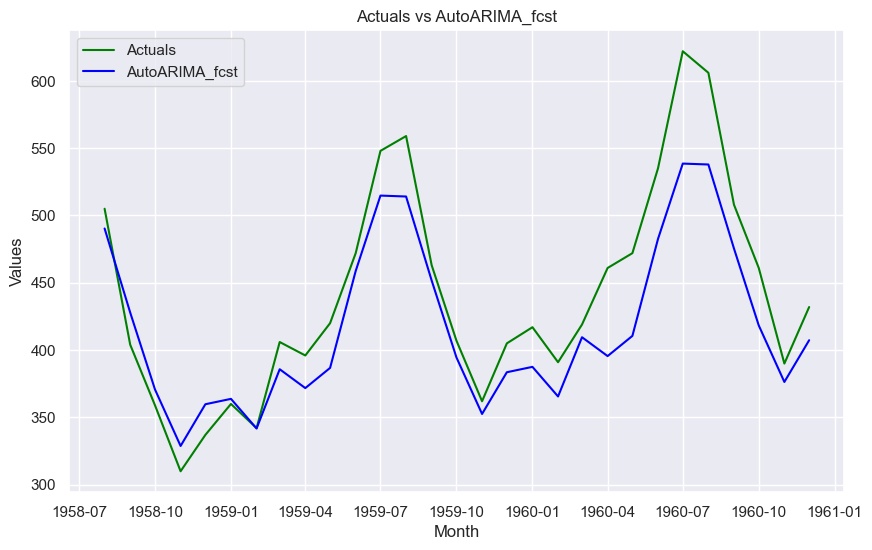

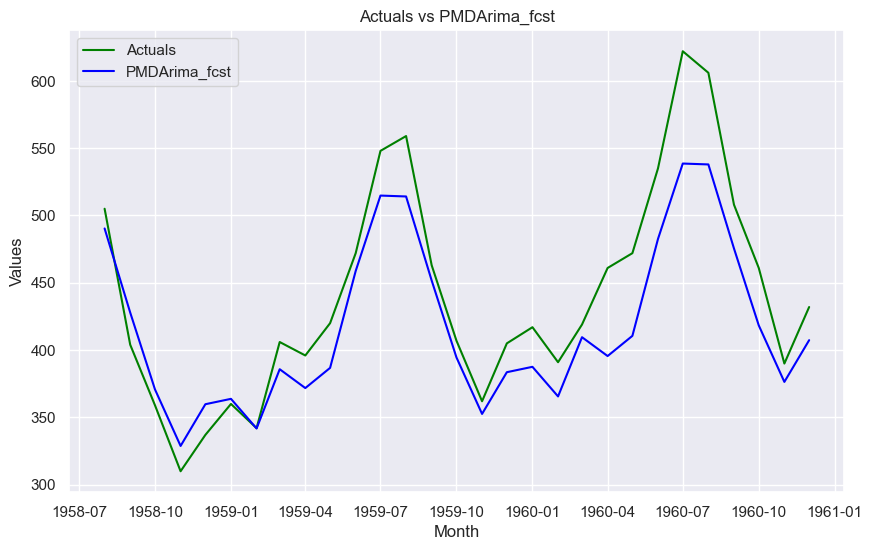

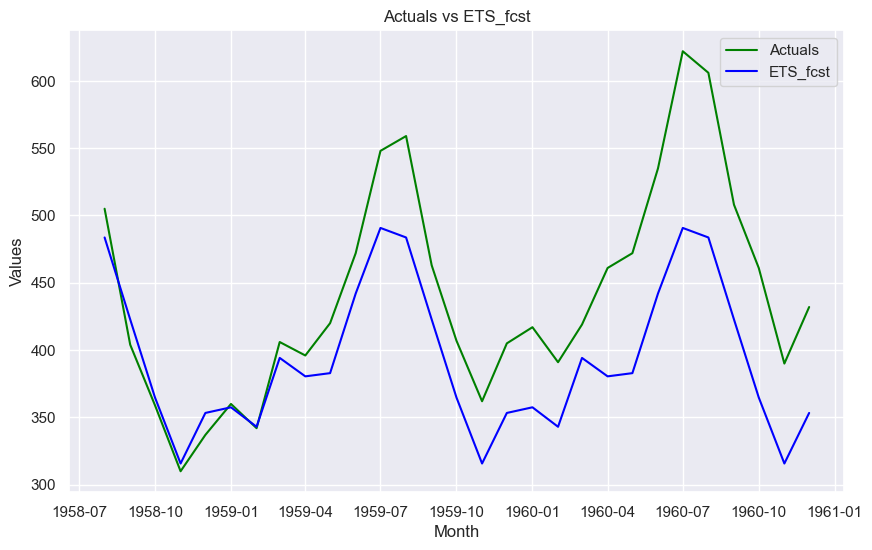

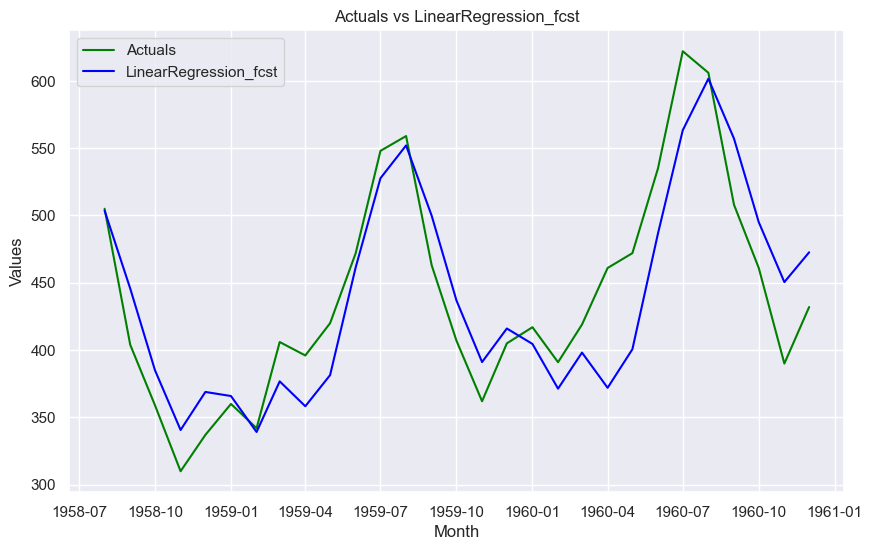

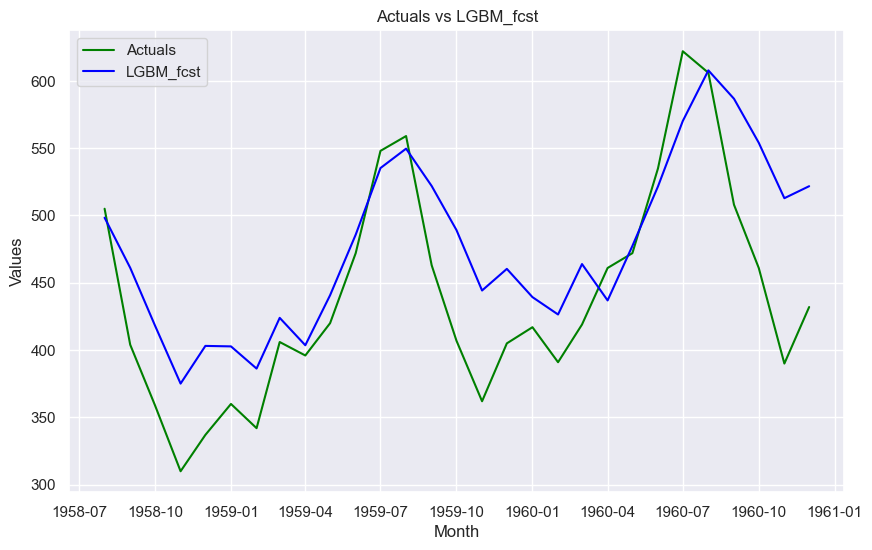

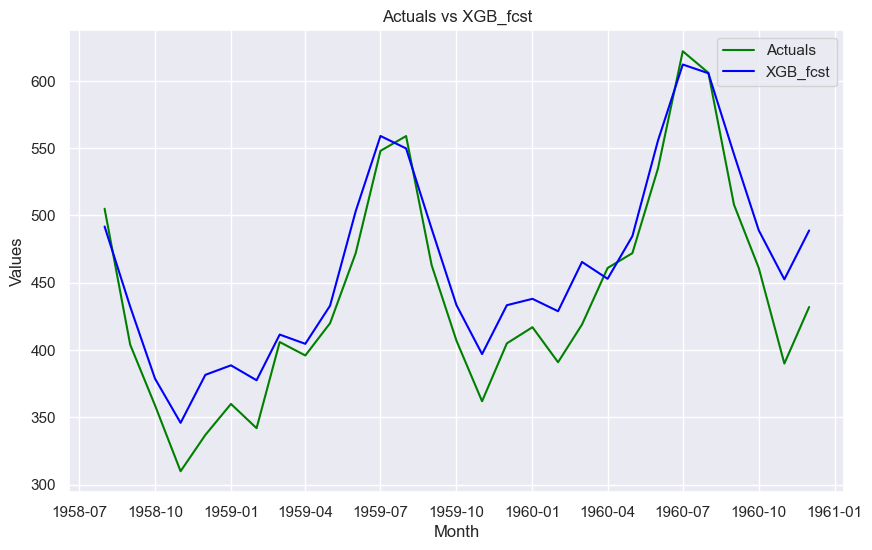

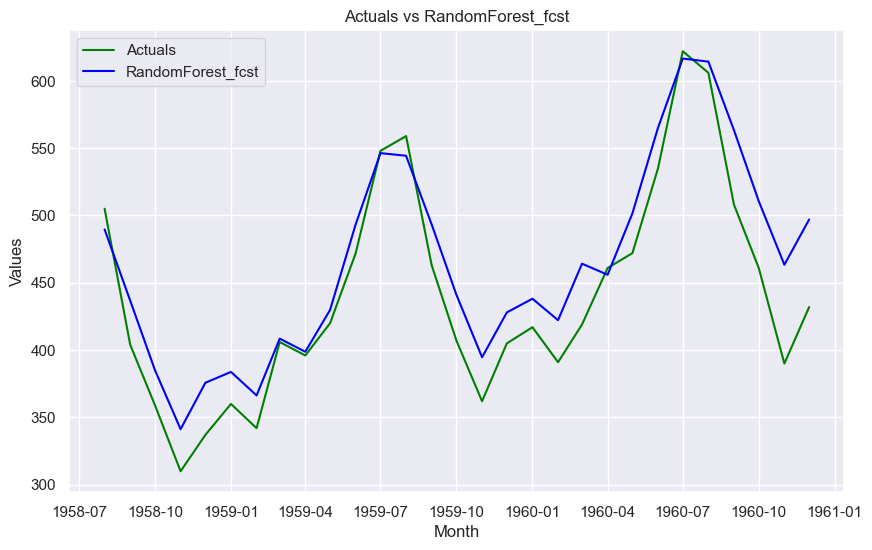

In [21]:
sns.set(style="darkgrid")

for col in fcst_result.columns[1:]:
    plt.figure(figsize=(10, 6))   
    plt.plot(fcst_result.index, fcst_result['#Passengers'], label='Actuals', color='green')
    plt.plot(fcst_result.index, fcst_result[col], label=col, color='blue')
    plt.title(f'Actuals vs {col}')
    plt.xlabel('Month')
    plt.ylabel('Values')
    plt.legend()
    plt.show()